In [2]:
deps <- c("ISLR", "ndjson", "ggplot2", "dplyr", "caret", "tidyr", "gridExtra", "data.table", "repr", "reshape2", "grid", "patchwork")
for (p in deps) {
    if (!requireNamespace(p, quietly = TRUE)) {
        install.packages(p, repos = "https://cran.rstudio.com")
    }
    library(p, character.only = TRUE)
}
options(scipen=999)

df <- ndjson::stream_in("./self_ensemble.jsonl")

df <- df[df$dataset == "cifar10",]
# df <- df[df$dataset == "cifar100",]
# df <- df[df$dataset == "imagenette",] # <- doesn't work due to a bug

# print(names(df))


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt


The following object is masked from ‘package:tidyr’:

    smiths




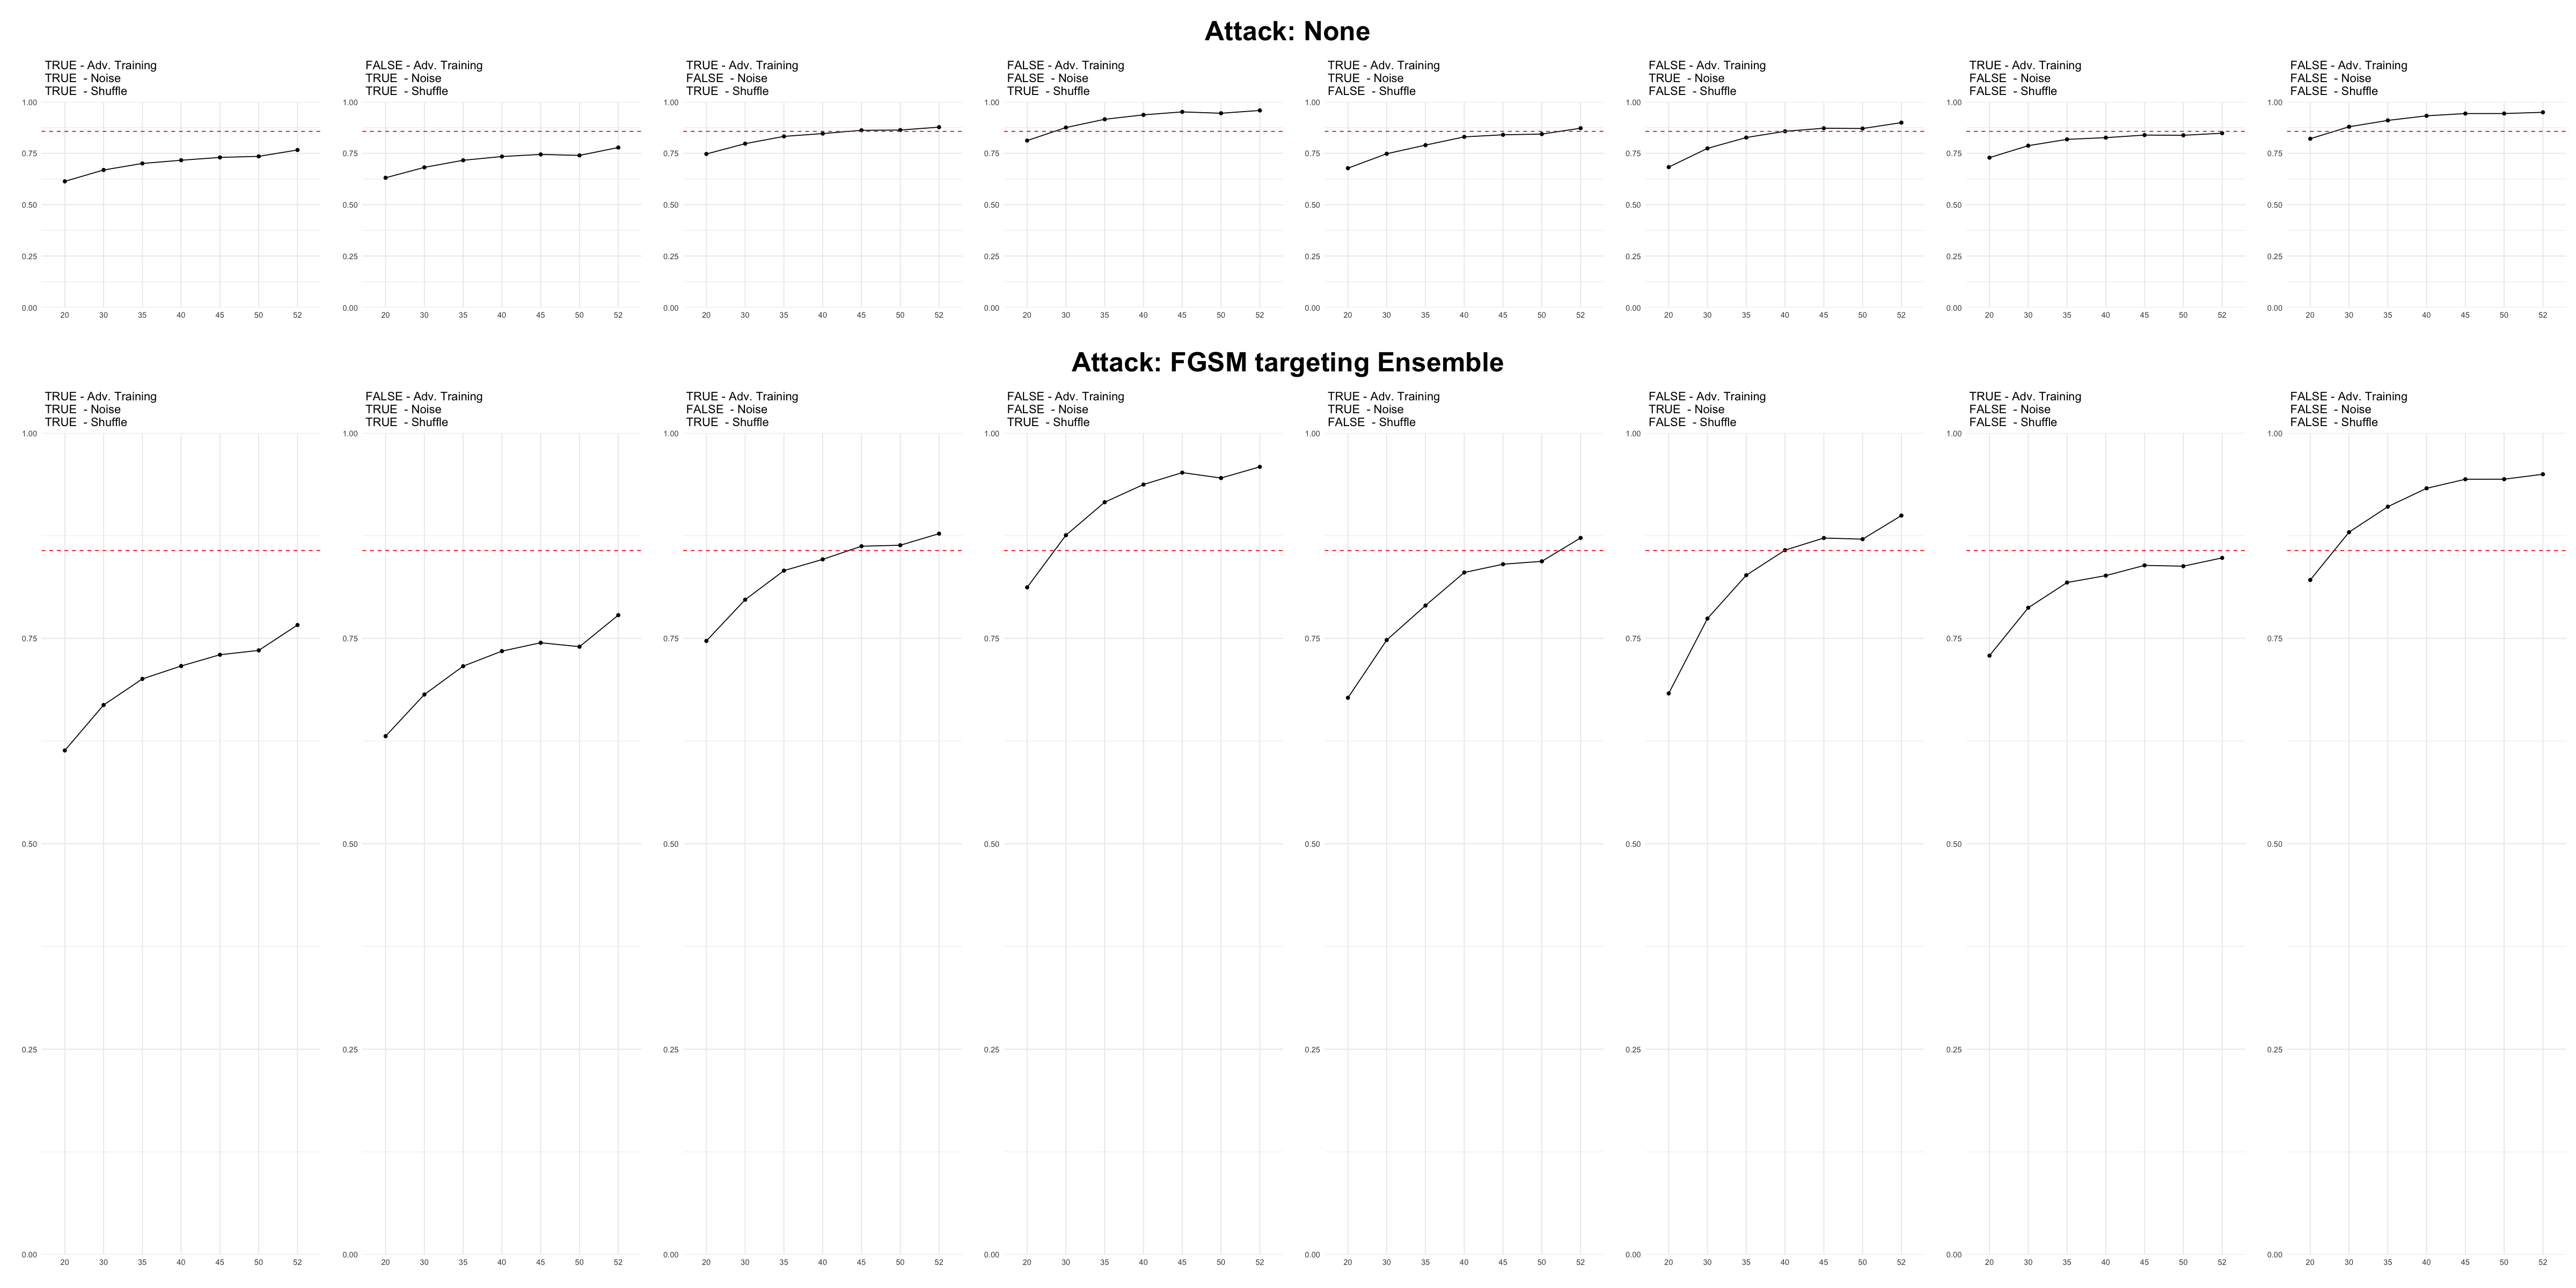

In [4]:
options(repr.plot.width=40, repr.plot.height=20)


get_plot <- function(acc_cols, acc_ensemble) {
    plots <- list()
    
    combs <- expand.grid(
        training_adversarial = c(TRUE, FALSE),
        training_noise = c(TRUE, FALSE),
        training_shuffle = c(TRUE, FALSE)
    )
    for (i in 1:nrow(combs)) {
        filtered_df <- df[df$training_adversarial == combs$training_adversarial[i] &
                       df$training_noise == combs$training_noise[i] &
                       df$training_shuffle == combs$training_shuffle[i], ]
        melted_df <- melt(filtered_df, measure.vars = acc_cols)

        p <- ggplot() +
            geom_line(data = melted_df, aes(x = variable, y = value, group = 1), color = "black") +
            geom_point(data = melted_df, aes(x = variable, y = value), color = "black") +
            geom_hline(yintercept = df[[acc_ensemble]][2], color = "red", linetype = "dashed", linewidth = 0.5) +
            xlab("") +
            ylab("") +
            theme_minimal() +
            scale_y_continuous(expand = c(0, 0), limits = c(0, 1)) + # limit y range
            scale_x_discrete(labels = function(x) sub(".*\\.", "", x)) + # show only layer number on x-axis
            ggtitle(paste(
                "", 
                combs$training_adversarial[i], "- Adv. Training \n",
                combs$training_noise[i], " - Noise \n",
                combs$training_shuffle[i], " - Shuffle"
            ))
        plots[[i]] <- p
    }

    combined_plot <- patchwork::wrap_plots(plots, ncol = 8)
    return(combined_plot)
}

grids <- list()

description <- "Attack: None"
acc_cols <- c("plain_layer_accs.20", "plain_layer_accs.30", "plain_layer_accs.35", "plain_layer_accs.40", "plain_layer_accs.45", "plain_layer_accs.50", "plain_layer_accs.52")
acc_ensemble <- "plain_ensemble_acc"
p <- get_plot(acc_cols, acc_ensemble)
grids[[1]] <- p

description <- "Attack: FGSM targeting Ensemble"
acc_cols <- c("fgsmensemble_layer_accs.20", "fgsmensemble_layer_accs.30", "fgsmensemble_layer_accs.35", "fgsmensemble_layer_accs.40", "fgsmensemble_layer_accs.45", "fgsmensemble_layer_accs.50", "fgsmensemble_layer_accs.52")
acc_ensemble <- "fgsmensemble_ensemble_acc"
grids[[2]] <- p

description <- "Attack: FGSM targeting Layer"
acc_cols <- c("fgsmensemble_layer_accs.20", "fgsmensemble_layer_accs.30", "fgsmensemble_layer_accs.35", "fgsmensemble_layer_accs.40", "fgsmensemble_layer_accs.45", "fgsmensemble_layer_accs.50", "fgsmensemble_layer_accs.52")
acc_ensemble <- "fgsmensemble_ensemble_acc"
p <- get_plot(acc_cols, acc_ensemble)
grids[[3]] <- p

title1 <- textGrob("Attack: None", gp = gpar(fontsize = 30, fontface = "bold"))
title2 <- textGrob("Attack: FGSM targeting Ensemble", gp = gpar(fontsize = 30, fontface = "bold"))

grids_no_title <- lapply(grids, function(p) p + plot_annotation(title = NULL))

p <- wrap_plots(
  list(
    title1, grids_no_title[[1]],
    title2, grids_no_title[[2]]
  ),
  ncol = 1,
  heights = c(1, 20, 1, 20) # control spacing
)
print(p)



# fgsmensemble

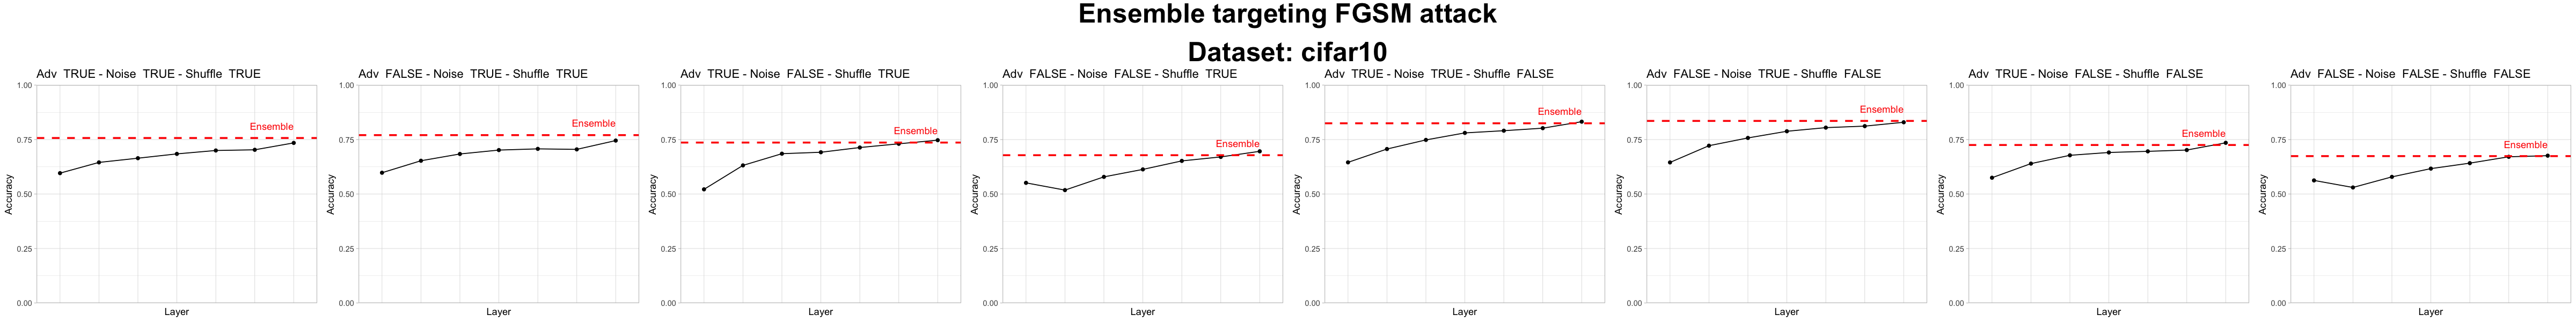

In [13]:
options(repr.plot.width=40, repr.plot.height=5)

acc_cols <- c("fgsmensemble_layer_accs.20", "fgsmensemble_layer_accs.30", "fgsmensemble_layer_accs.35", "fgsmensemble_layer_accs.40", "fgsmensemble_layer_accs.45", "fgsmensemble_layer_accs.50", "fgsmensemble_layer_accs.52")

for (ds in unique(df$dataset)) {
    df_ds <- df[df$dataset == ds,]

    plots <- list()
    combs <- expand.grid(
        training_adversarial = c(TRUE, FALSE),
        training_noise = c(TRUE, FALSE),
        training_shuffle = c(TRUE, FALSE)
    )
    for (i in 1:nrow(combs)) {
        filtered_df <- df_ds[df_ds$training_adversarial == combs$training_adversarial[i] &
                       df_ds$training_noise == combs$training_noise[i] &
                       df_ds$training_shuffle == combs$training_shuffle[i], ]
      
        melted_df <- melt(filtered_df, measure.vars = acc_cols)
      
        p <- ggplot(data = melted_df, aes(x = variable, y = value, group = 1)) +
            geom_line() +
            geom_point() +
            ggtitle(paste(
                "Adv ", combs$training_adversarial[i],
                "- Noise ", combs$training_noise[i],
                "- Shuffle ", combs$training_shuffle[i]
            )) +
            theme_light() +
            theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) +
            geom_hline(yintercept = filtered_df$fgsmensemble_ensemble_acc[1], color = "red", linetype = "dashed", size = 1) +
            annotate("text", x = length(acc_cols), y = filtered_df$fgsmensemble_ensemble_acc[1], label = "Ensemble", color = "red", vjust = -1.2, hjust = 1) +
            scale_y_continuous(expand = c(0, 0), limits = c(0, 1)) +
            xlab("Layer") +
            ylab("Accuracy")

        plots[[i]] <- p
    }

    grid.arrange(
        grobs = plots, 
        ncol = 8, 
        top = textGrob(paste("Ensemble targeting FGSM attack\nDataset:", ds), gp = gpar(fontsize = 30, fontface = "bold"))
    )
}


# fgsmcombined



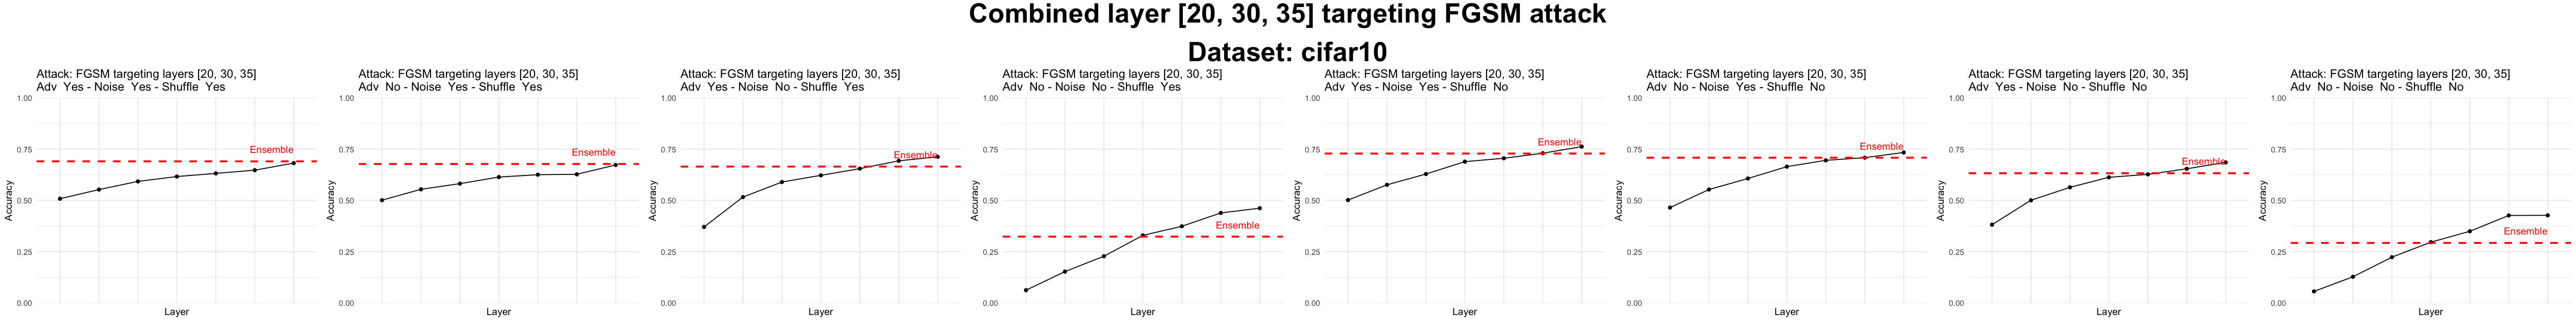

In [14]:
options(repr.plot.width=40, repr.plot.height=5)

acc_cols <- c("fgsmcombined_[20, 30, 35]_layer_accs.20", "fgsmcombined_[20, 30, 35]_layer_accs.30", "fgsmcombined_[20, 30, 35]_layer_accs.35", "fgsmcombined_[20, 30, 35]_layer_accs.40", "fgsmcombined_[20, 30, 35]_layer_accs.45", "fgsmcombined_[20, 30, 35]_layer_accs.50", "fgsmcombined_[20, 30, 35]_layer_accs.52")
ensemble_acc_col <- "fgsmcombined_[20, 30, 35]_ensemble_acc"

for (ds in unique(df$dataset)) {
    df_ds <- df[df$dataset == ds,]

    plots <- list()
    combs <- expand.grid(
        training_adversarial = c(TRUE, FALSE),
        training_noise = c(TRUE, FALSE),
        training_shuffle = c(TRUE, FALSE)
    )
    for (i in 1:nrow(combs)) {
        filtered_df <- df_ds[df_ds$training_adversarial == combs$training_adversarial[i] &
                       df_ds$training_noise == combs$training_noise[i] &
                       df_ds$training_shuffle == combs$training_shuffle[i], ]
      
        melted_df <- melt(filtered_df, measure.vars = acc_cols)
      
        p <- ggplot(data = melted_df, aes(x = variable, y = value, group = 1)) +
            geom_line() +
            geom_point() +
            ggtitle(paste(
                "Attack: FGSM targeting layers [20, 30, 35]",
                "\nAdv ", ifelse(combs$training_adversarial[i], "Yes", "No"),
                "- Noise ", ifelse(combs$training_noise[i], "Yes", "No"),
                "- Shuffle ", ifelse(combs$training_shuffle[i], "Yes", "No")
            )) +
            theme_minimal() +
            theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) +
            geom_hline(yintercept = filtered_df[[ensemble_acc_col]][1], color = "red", linetype = "dashed", size = 1) +
            annotate("text", x = length(acc_cols), y = filtered_df[[ensemble_acc_col]][1], label = "Ensemble", color = "red", vjust = -1.2, hjust = 1) +
            scale_y_continuous(expand = c(0, 0), limits = c(0, 1)) +
            xlab("Layer") +
            ylab("Accuracy")

        plots[[i]] <- p
    }

    grid.arrange(
        grobs = plots, 
        ncol = 8, 
        top = textGrob(paste("Combined layer [20, 30, 35] targeting FGSM attack\nDataset:", ds), gp = gpar(fontsize = 30, fontface = "bold"))
    )
}

# mask

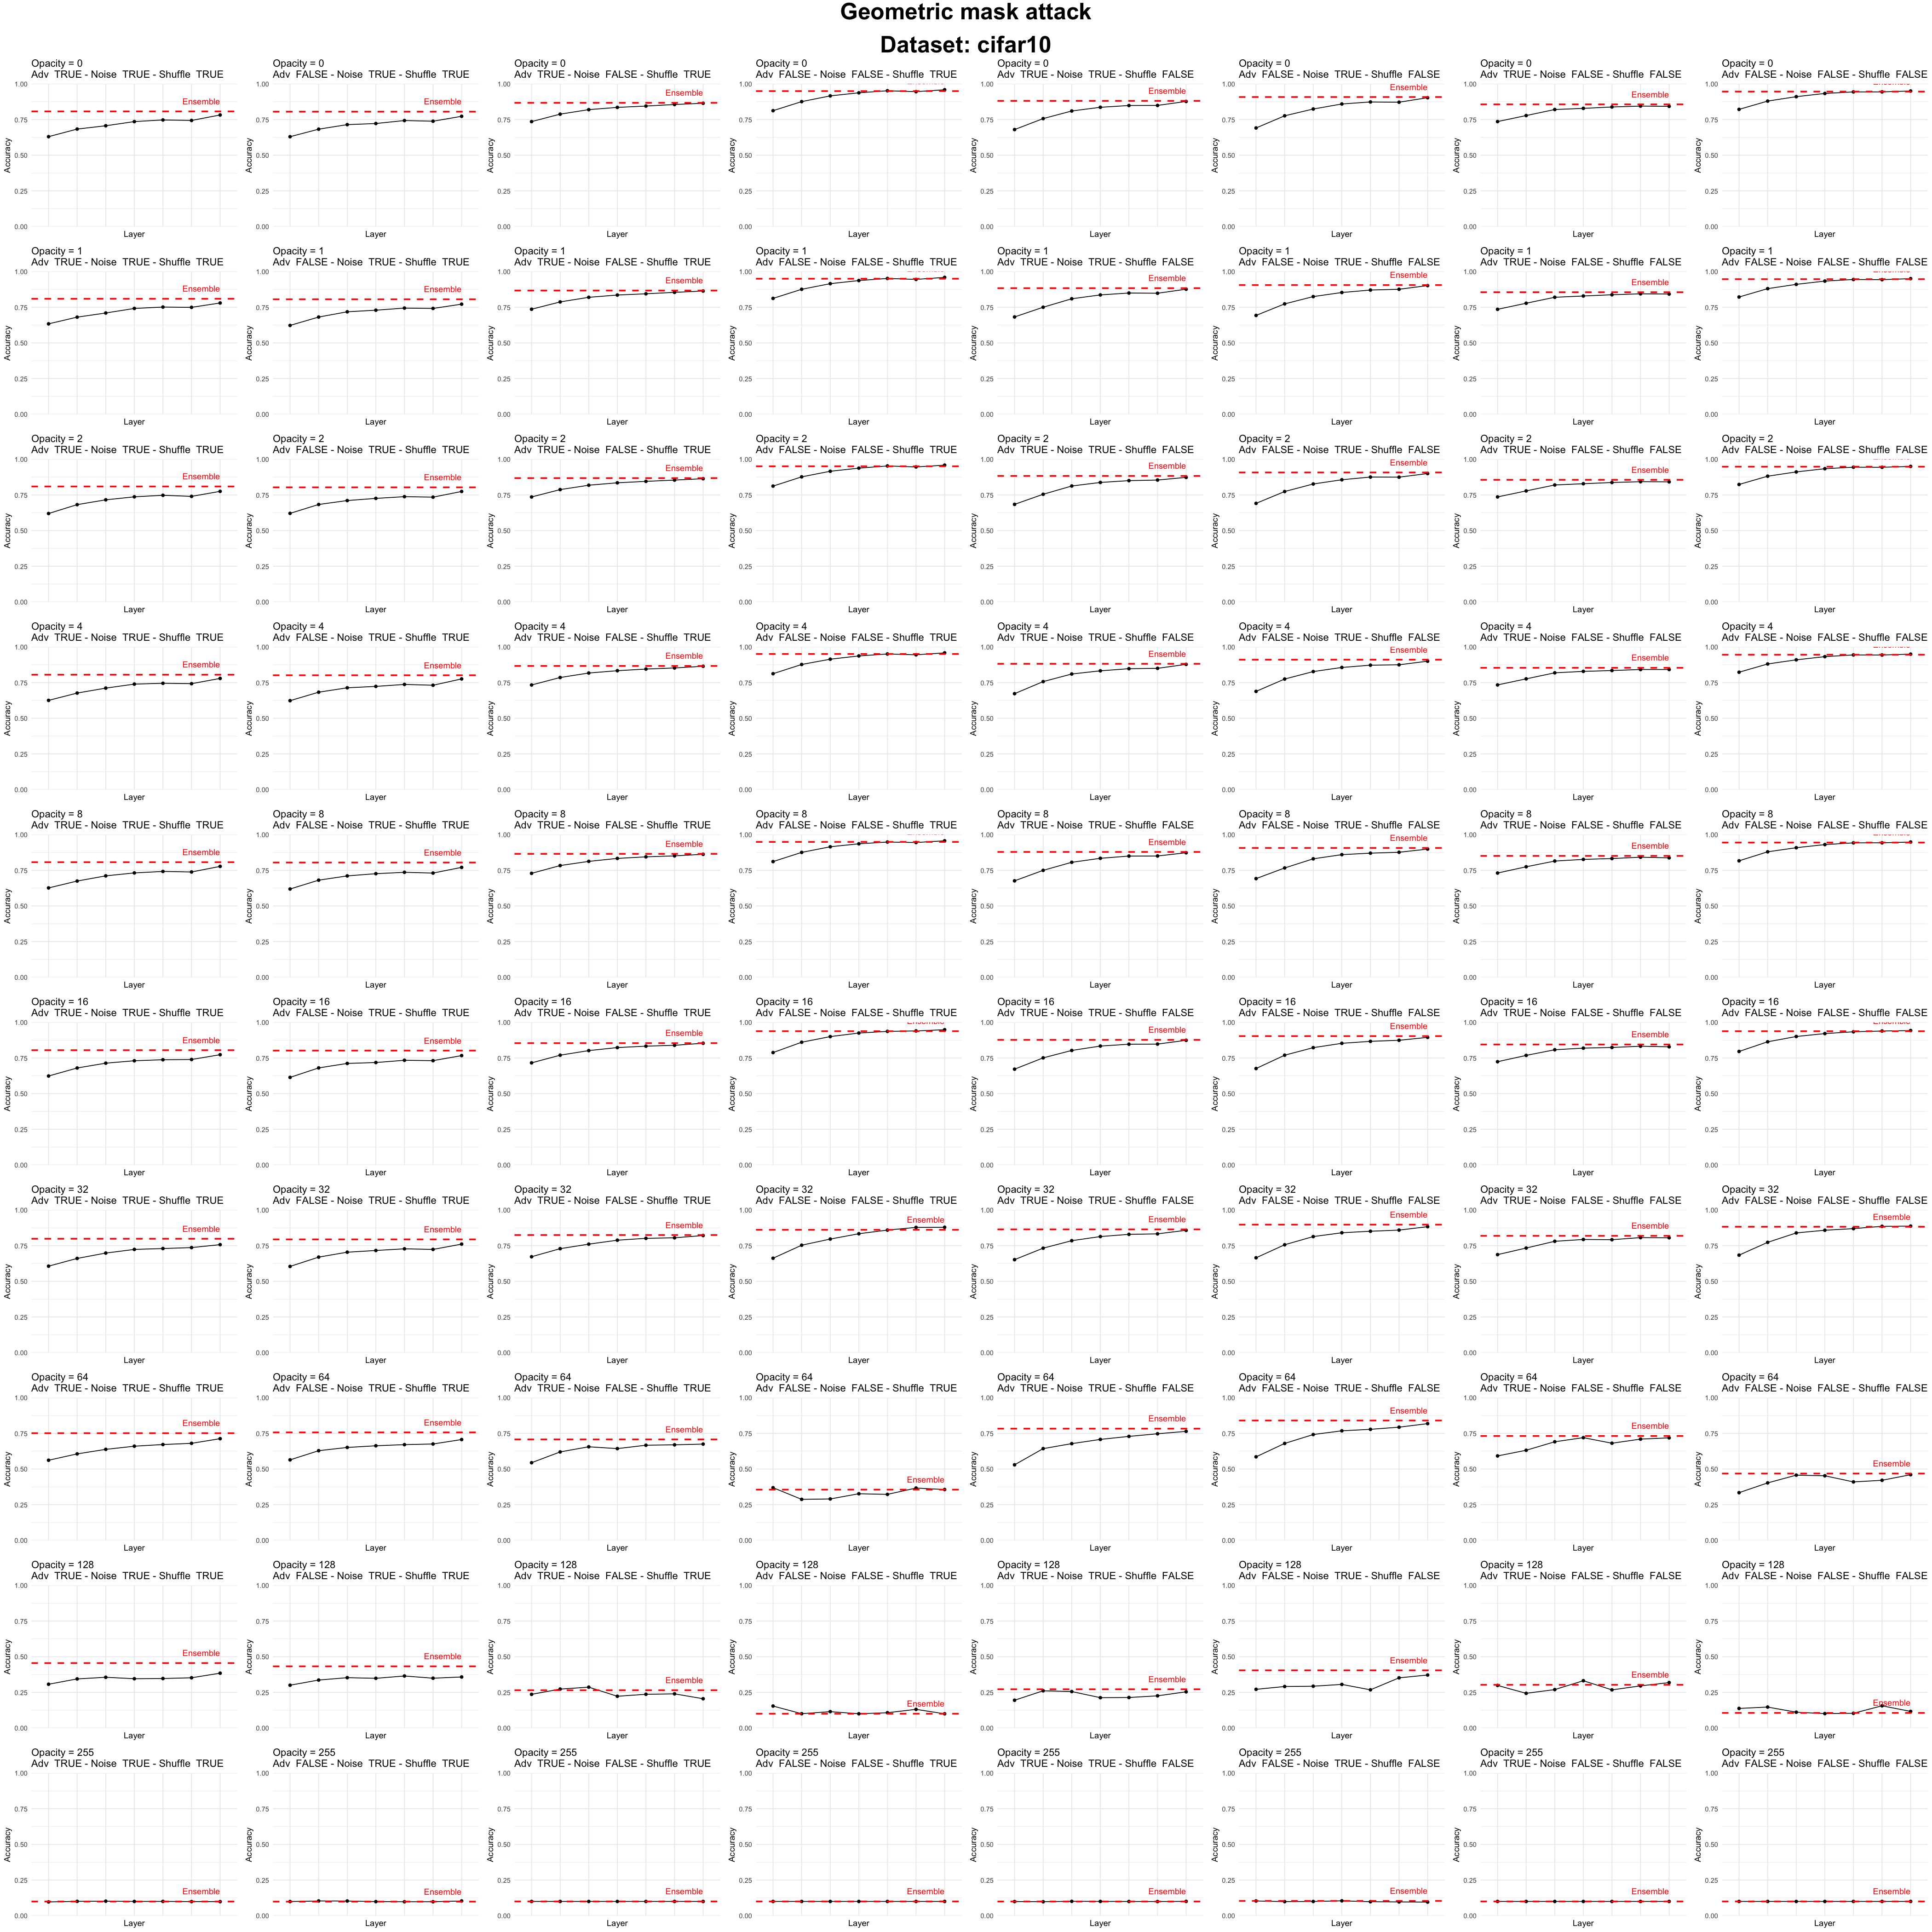

In [15]:
options(repr.plot.width=35, repr.plot.height=35)

opacities <- c(0, 1, 2, 4, 8, 16, 32, 64, 128, 255)
layers <- c(20, 30, 35, 40, 45, 50, 52)

all_plots <- list()
plot_counter <- 1

for (opacity in opacities) {

    acc_cols <- paste0("mask_", opacity, "_layer_accs.", layers)
    ensemble_acc_col <- paste0("mask_", opacity, "_ensemble_acc")

    for (ds in unique(df$dataset)) {
        df_ds <- df[df$dataset == ds,]

        plots <- list()
        combs <- expand.grid(
            training_adversarial = c(TRUE, FALSE),
            training_noise = c(TRUE, FALSE),
            training_shuffle = c(TRUE, FALSE)
        )
        for (i in 1:nrow(combs)) {
            filtered_df <- df_ds[df_ds$training_adversarial == combs$training_adversarial[i] &
                        df_ds$training_noise == combs$training_noise[i] &
                        df_ds$training_shuffle == combs$training_shuffle[i], ]
        
            melted_df <- melt(filtered_df, measure.vars = acc_cols)
        
            p <- ggplot(data = melted_df, aes(x = variable, y = value, group = 1)) +
                geom_line() +
                geom_point() +
                ggtitle(paste(
                    "Opacity =", opacity,
                    "\nAdv ", combs$training_adversarial[i],
                    "- Noise ", combs$training_noise[i],
                    "- Shuffle ", combs$training_shuffle[i]
                )) +
                theme_minimal() +
                theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) +
                geom_hline(yintercept = filtered_df[[ensemble_acc_col]][1], color = "red", linetype = "dashed", size = 1) +
                annotate("text", x = length(acc_cols), y = filtered_df[[ensemble_acc_col]][1], label = "Ensemble", color = "red", vjust = -1.2, hjust = 1) +
                scale_y_continuous(expand = c(0, 0), limits = c(0, 1)) +
                xlab("Layer") +
                ylab("Accuracy")

            # plots[[i]] <- p
            all_plots[[plot_counter]] <- p
            plot_counter <- plot_counter + 1

        }

        # gridExtra::grid.arrange(grobs = plots, ncol = 8, top = paste("Dataset:", ds, " - Mask Opacity:", opacity))
    }
}

grid.arrange(
    grobs = all_plots, 
    ncol = 8,
    nrow = 10,
    top = textGrob(paste("Geometric mask attack\nDataset:", ds), gp = gpar(fontsize = 30, fontface = "bold"))
)

# fgsm20-52

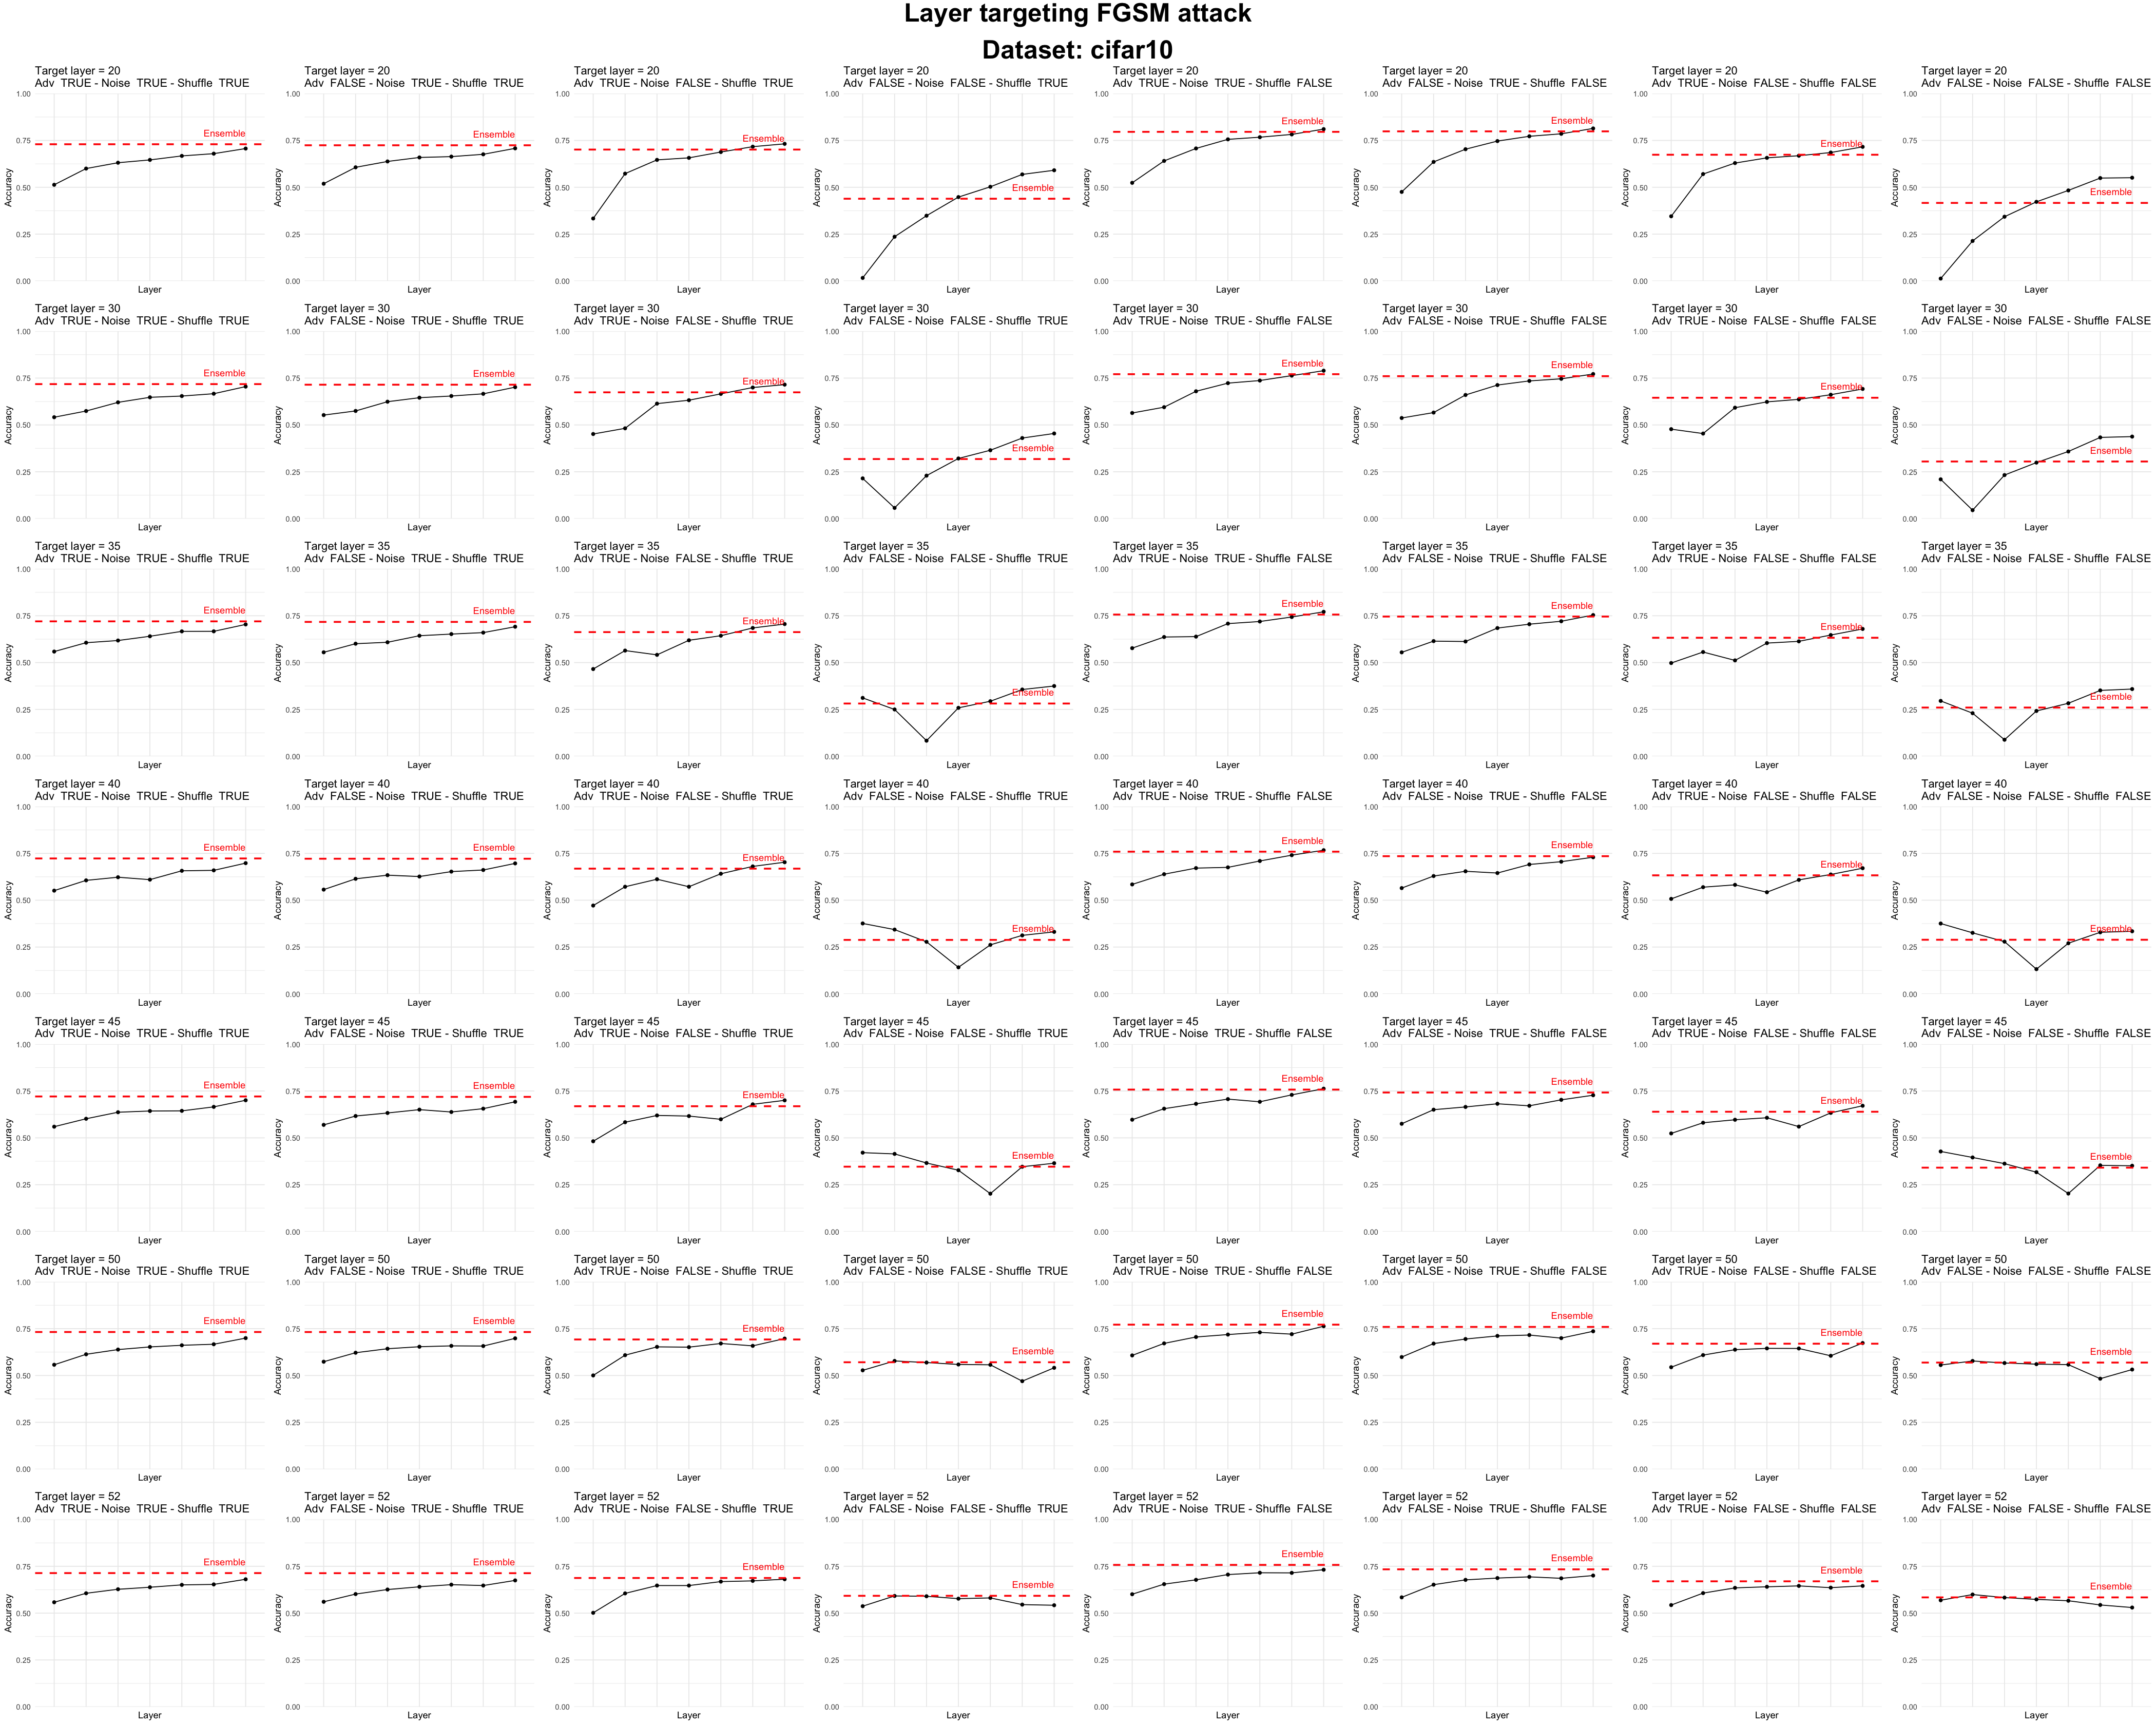

: 

In [16]:
options(repr.plot.width=35, repr.plot.height=28)
all_plots <- list()
plot_counter <- 1

for (layer in layers) {
    acc_cols <- paste0("fgsm_", layer, "_layer_accs.", layers)
    ensemble_acc_col <- paste0("fgsm_", layer, "_ensemble_acc")

    for (ds in unique(df$dataset)) {
        df_ds <- df[df$dataset == ds,]

        combs <- expand.grid(
            training_adversarial = c(TRUE, FALSE),
            training_noise = c(TRUE, FALSE),
            training_shuffle = c(TRUE, FALSE)
        )
        
        for (i in 1:nrow(combs)) {
            filtered_df <- df_ds[df_ds$training_adversarial == combs$training_adversarial[i] &
                        df_ds$training_noise == combs$training_noise[i] &
                        df_ds$training_shuffle == combs$training_shuffle[i], ]
        
            melted_df <- melt(filtered_df, measure.vars = acc_cols)
        
            p <- ggplot(data = melted_df, aes(x = variable, y = value, group = 1)) +
                geom_line() +
                geom_point() +
                ggtitle(paste(
                    "Target layer =", layer,
                    "\nAdv ", combs$training_adversarial[i],
                    "- Noise ", combs$training_noise[i],
                    "- Shuffle ", combs$training_shuffle[i]
                )) +
                theme_minimal() +
                theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) +
                geom_hline(yintercept = filtered_df[[ensemble_acc_col]][1], color = "red", linetype = "dashed", size = 1) +
                annotate("text", x = length(acc_cols), y = filtered_df[[ensemble_acc_col]][1], label = "Ensemble", color = "red", vjust = -1.2, hjust = 1) +
                scale_y_continuous(expand = c(0, 0), limits = c(0, 1)) +
                xlab("Layer") +
                ylab("Accuracy")

            all_plots[[plot_counter]] <- p
            plot_counter <- plot_counter + 1
        }
    }
}

grid.arrange(
    grobs = all_plots, 
    ncol = 8, 
    nrow = 7,
    top = textGrob(paste("Layer targeting FGSM attack\nDataset:", ds), gp = gpar(fontsize = 30, fontface = "bold"))
)